# 1. 可视化数据预处理

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
from dateutil.parser import parser
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
crime = pd.read_csv('Chicago_Crimes_2012_to_2017.csv',usecols=['ID','Case Number','Date','Year','Block','Primary Type','Description','Location Description','Arrest','Domestic','District','Latitude','Longitude']
                    ,index_col=['ID'])
print(display(crime.head()))
print(crime.info())
print(crime.isnull().mean()) # 查看缺失值所占的比例
print(crime.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99]).T)

d:\study\python\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Case Number,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,Year,Latitude,Longitude
ID,,,,,,,,,,,,
10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,10.0,2016,41.864073,-87.706819
10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,3.0,2016,41.782922,-87.604363
10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,15.0,2016,41.894908,-87.758372
10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,BATTERY,SIMPLE,SIDEWALK,False,False,15.0,2016,41.885687,-87.749516
10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,THEFT,$500 AND UNDER,RESIDENCE,False,True,15.0,2016,41.886297,-87.761751


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456714 entries, 10508693 to 10508692
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Case Number           1456713 non-null  object 
 1   Date                  1456714 non-null  object 
 2   Block                 1456714 non-null  object 
 3   Primary Type          1456714 non-null  object 
 4   Description           1456714 non-null  object 
 5   Location Description  1455056 non-null  object 
 6   Arrest                1456714 non-null  bool   
 7   Domestic              1456714 non-null  bool   
 8   District              1456713 non-null  float64
 9   Year                  1456714 non-null  int64  
 10  Latitude              1419631 non-null  float64
 11  Longitude             1419631 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 125.0+ MB
None
Case Number             6.864765e-07
Date             

## 1.1 缺失值/日期处理

In [3]:
data = crime.copy()

# Location Description 缺失值较少，选择用众数填补
data['Location Description'] = data['Location Description'].fillna(value=data['Location Description'].value_counts().idxmax())

# Latitude和Longitude有大量缺失值，由于经纬度缺失值不能用任何一种方法填补，而且本次数据分析本身不需要这两列，所以先单独保存在另一个表格中,以备后续使用
data_lng_lat = data.dropna()
data_lng_lat = data_lng_lat.loc[data_lng_lat['Latitude']>36.7,:]

# 将Latitude和Longitude从列表中删除后将缺失值为1的District删掉
data = data.drop(labels=['Latitude','Longitude'],axis=1)
data = data.dropna()

# 2017年不是全年数据，删除
year_grouped = data.groupby(data['Year']).count()
data = data.loc[data['Year']!=2017,:]

In [4]:
data['Date_ymd'] = pd.to_datetime(data['Date'],format='%m/%d/%Y %I:%M:%S %p')
data['Year'] = data['Year'].astype(str)
data['day_of_week'] = data['Date_ymd'].dt.dayofweek
data['quarter'] = data['Date_ymd'].dt.quarter
data['day_of_year'] = data['Date_ymd'].dt.dayofyear
data['day_of_month'] = data['Date_ymd'].dt.day
data['week_of_year'] = data['Date_ymd'].dt.weekofyear
data['hour_of_day'] = data['Date_ymd'].apply(lambda x: x.hour)
data['month'] = data['Date_ymd'].apply(lambda x: x.month)
data['District'] = data['District'].astype(str)

# 2. 数据可视化/总览

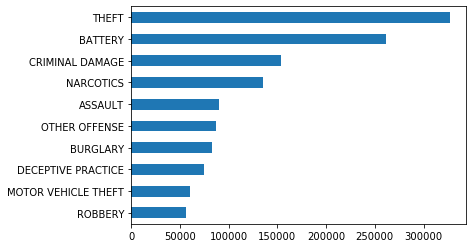

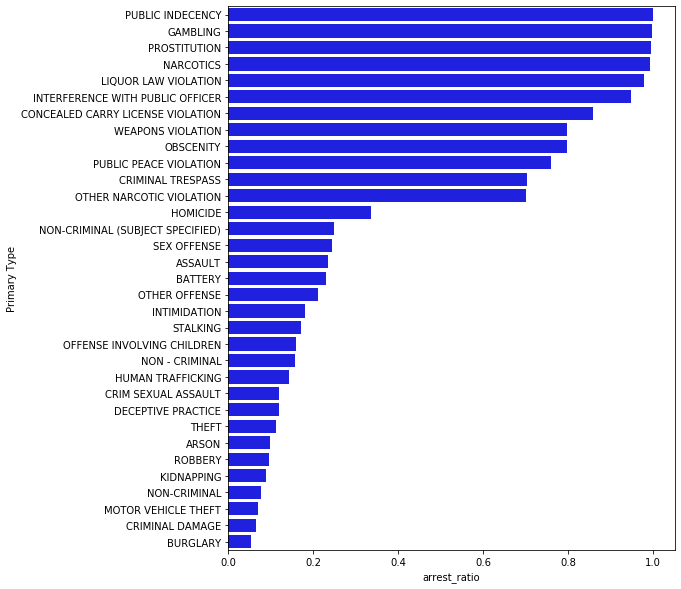

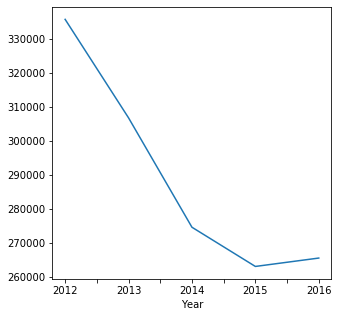

In [6]:
# 1. 2012-2016犯罪类型TOP10总数排名:
crime_type = data['Primary Type'].value_counts()[:10].sort_values().plot(kind='barh')

# 2. 犯罪类型的抓捕难易度排名
crime_arrest = data.groupby('Primary Type').sum()
crime_arrest['size'] = data.groupby('Primary Type').size()
crime_arrest['arrest_ratio'] = crime_arrest['Arrest']/crime_arrest['size']
crime_arrest = crime_arrest.sort_values(by='arrest_ratio',ascending=False)
plt.figure(figsize=(8,10))
sns.barplot(x='arrest_ratio',y=crime_arrest.index,data=crime_arrest,color='blue')

# 3. 逐年犯罪数量的变化(2012-2016)
plt.figure(figsize=(5,5))
data.groupby(data['Year']).size().plot(kind='line')

               ################# 分析 #################
# 最常见的犯罪类型有：偷窃，袭击罪，刑事毁坏，毒品相关，企图伤害罪，其他违反规则/法律等的行为最容易抓到的犯罪类型有：公然猥亵罪，赌博，卖淫嫖娼，毒品相关，违反酒类相关法律规定，袭警罪
# 逐年犯罪数量的变化：2012到2015年急速下降，2016年较2015年略微上升。

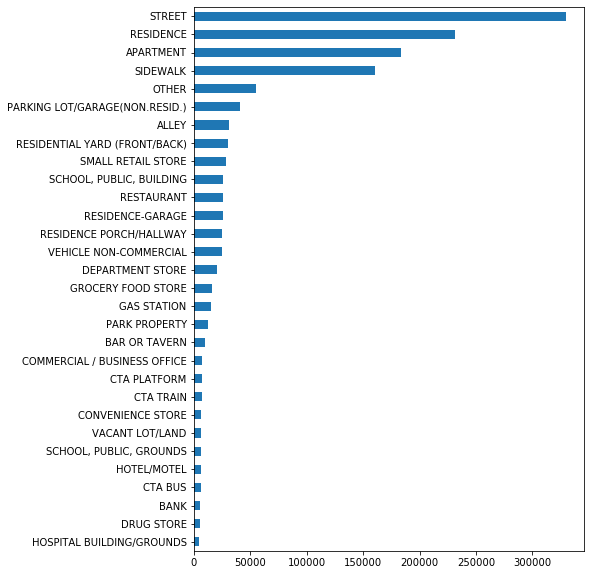

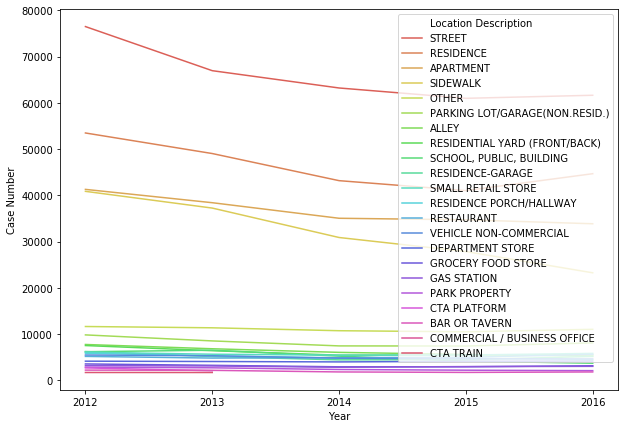

In [8]:
# 4. 犯罪地点(Location Description)的犯罪频次TOP30排名
plt.figure(figsize=(7,10))
crime_ld = data['Location Description'].value_counts()[:30].sort_values().plot(kind='barh')

# 5. 各个Location Description的逐年犯罪数量的统计
grouped2 = data.groupby(['Year','Location Description']).count()[['Case Number']].reset_index()
group_ld = grouped2.sort_values(by='Case Number',ascending=False)[:100]
plt.figure(figsize=(10,7))
sns.lineplot(x='Year',y='Case Number',hue='Location Description',data=group_ld,palette=(sns.hls_palette(22)))
plt.legend(loc='upper right')
                    ################# 分析 #################
# 犯罪发生在街道，住宅区，公寓，马路和非住宅区的停车场的的几率较大，而且在其他几个犯罪类型都逐年下降的同时，在住宅区2016年发生犯罪的数量较2015年有较明显上升。

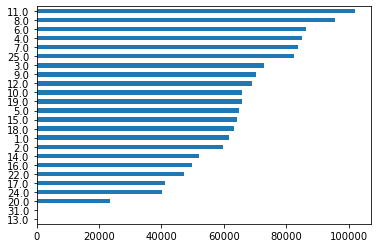

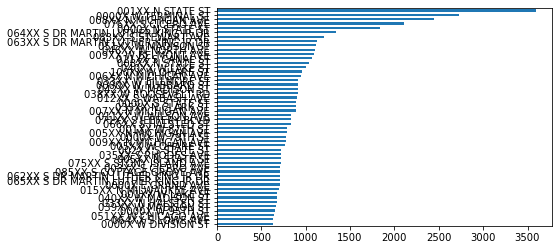

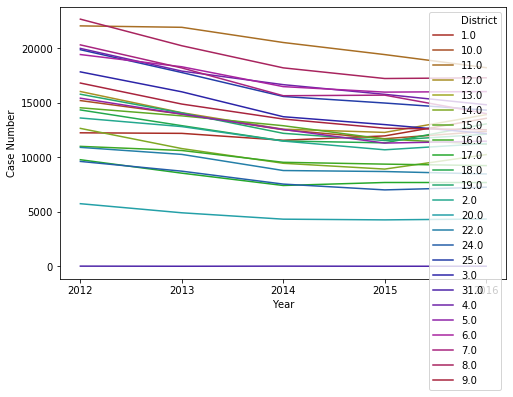

In [11]:
# 5. 犯罪地点（District）的犯罪频次排名
plt.figure(figsize=(6,4))
crime_ds = data['District'].value_counts().sort_values().plot(kind='barh')

# 6. 犯罪地点(Blok)的犯罪频次TOP50排名
plt.figure(figsize=(6,4))
crime_block = data['Block'].value_counts()[:50].sort_values().plot(kind='barh')

# 7. 各个District的逐年犯罪数量的统计
grouped = data.groupby(['Year','District']).count()[['Case Number']].reset_index().sort_values(by='Case Number',ascending=False)
plt.figure(figsize=(8,5))
sns.lineplot(x='Year',y='Case Number',hue='District',data=grouped,palette=(sns.hls_palette(24,l=.4)))
plt.legend(loc='best')

          ################# 分析 #################
# 根据犯罪地点District和Block的排名可知哪些地点比较危险，分别对应什么犯罪类型等，另根据下图可知有些犯罪地点出现大量空白，可根据改数据调整警力等措施。

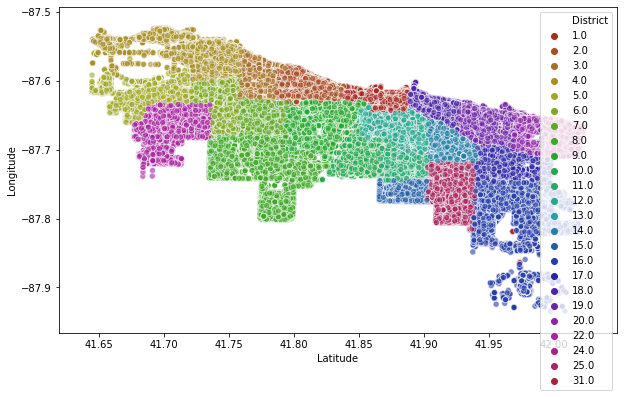

In [14]:
# 8. 可视化犯罪地区
plt.figure(figsize=(10,6))
sns.scatterplot(x='Latitude',y='Longitude',hue='District',alpha=0.6,data=data_lng_lat,palette=(sns.hls_palette(24,l=.4)))
plt.legend(loc='upper right')

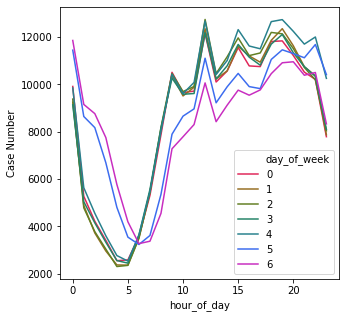

In [17]:
# 9. 关于时间的分析
grouped_data = data.groupby(['hour_of_day','day_of_week']).count()[['Case Number']].reset_index()
plt.figure(figsize=(5,5))
sns.lineplot(x='hour_of_day',y='Case Number',hue='day_of_week',data=grouped_data,palette=(sns.husl_palette(7,l=.5)))

None


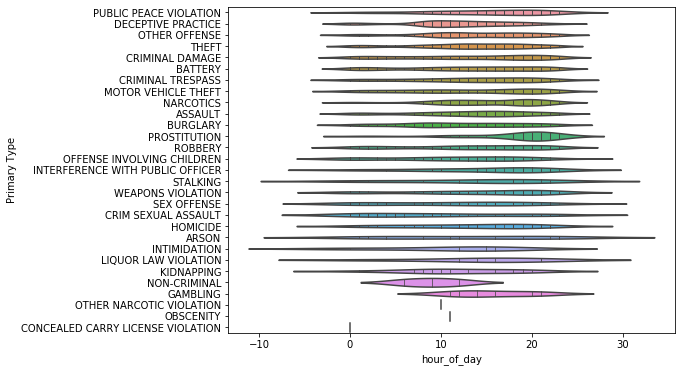

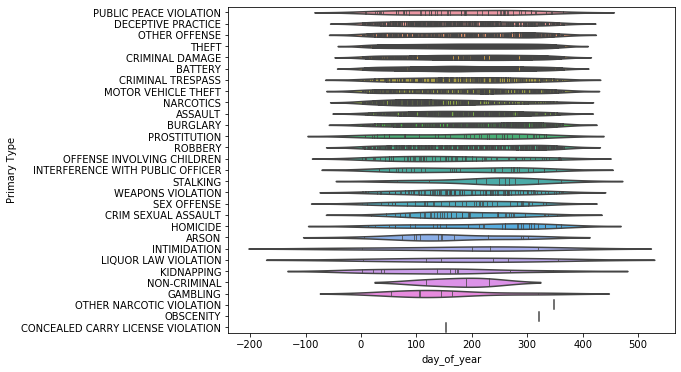

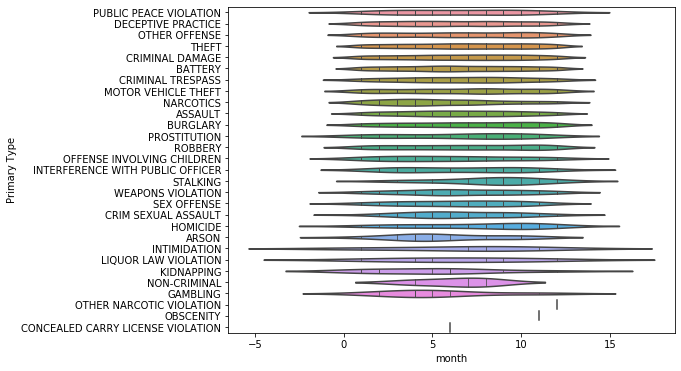

In [21]:
viol_2016 = data.loc[data['Year']=='2016',:]
sample = viol_2016.sample(n=10000)
def time_PrimaryType(data):
    list_ = ['hour_of_day','day_of_year','month']
    for i in list_:
        plt.figure(figsize=(8,6))
        sns.violinplot(x=i,y='Primary Type',data=sample,inner='stick')
print(time_PrimaryType(sample))
################# 分析 #################
# 根据观察小提琴图中不同犯罪类型在2016年哪个月，哪一季度，哪一天，一天中的哪个时辰的犯罪数量可大致看出哪个犯罪类型有不寻常的表现，这里由于电脑性能问题随即取了10000(总265462)条数据作为样本,数量较少不足以表现整体。
# 根据观察条形图可知，在每天凌晨5点左右犯罪人数较少，周四的18点左右，周三周四的上午12点左右犯罪人数较多。

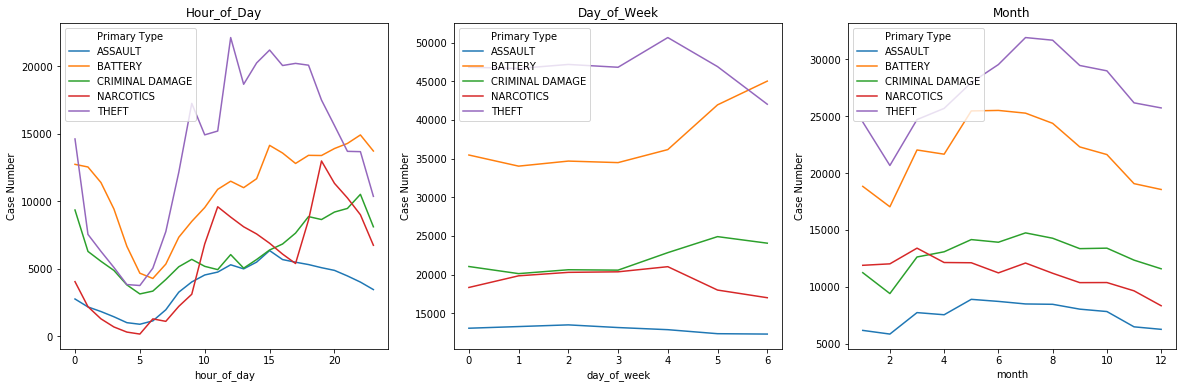

In [22]:
# 10. TOP5 犯罪类型最易发生的时间点/星期/月份
sample_top5 = data.loc[data['Primary Type'].isin(data['Primary Type'].value_counts().sort_values(ascending=False)[:5].keys().tolist())]

fig = plt.figure(figsize=(20,6))
top5_hourofday = sample_top5.groupby(['hour_of_day','Primary Type']).count()[['Case Number']].reset_index()
ax1 = fig.add_subplot(1,3,1)
sns.lineplot(x='hour_of_day',y='Case Number',hue='Primary Type',data=top5_hourofday)
ax1.set_title('Hour_of_Day')
ax1.legend(loc='upper left')

top5_dayofweek = sample_top5.groupby(['day_of_week','Primary Type']).count()[['Case Number']].reset_index()
ax2 = fig.add_subplot(1,3,2)
sns.lineplot(x='day_of_week',y='Case Number',hue='Primary Type',data=top5_dayofweek)
ax2.set_title('Day_of_Week')
ax2.legend(loc='upper left')

top5_month = sample_top5.groupby(['month','Primary Type']).count()[['Case Number']].reset_index()
ax3 = fig.add_subplot(1,3,3)
sns.lineplot(x='month',y='Case Number',hue='Primary Type',data=top5_month)
ax3.set_title('Month')
ax3.legend(loc='upper left')
                                      ################# 分析 #################
# 在2012至2016年最常见的犯罪类型中前五，按一天中发生的频率来看，偷窃在10am-15pm发生频率最高，毒品相关的犯罪有两个高峰期，11am和20pm左右，低峰期为17pm左右，其他都是凌晨5am为最低峰，随时间缓慢上升。
# 在2012至2016年最常见的犯罪类型中前五，按星期几的发生频率来看，企图伤害罪，毒品相关，刑事毁坏罪发生较为平均，偷窃的高峰发生在星期五，在周末有所下降，袭击罪相反，从周五开始到周日一直呈上升状。
# 在2012至2016年最常见的犯罪类型中前五，按月份的发生频率来看，都大致呈现拱形状，即5，6，7，8月为高峰，12，2，11，12月为低谷。其中发生在7，8月份的偷窃罪最多，发生在5，6月份的袭击罪最多。
# 综上，偷窃罪的高发期为7，8月份的星期五12pm至1pm左右，在街道，住宅区，公寓要小心；袭击罪的高发期为每年5，6，7月份的周末的下午到晚上，在公寓要格外小心，住宅区，人行道和街道上其次。

# 3. 随机森林Primary Type 预测

## 3.1 数据预处理

In [24]:
data_rfc = data[['Primary Type','Description','Location Description','Domestic','District','Year','day_of_week','quarter','day_of_month','hour_of_day','month']]
# 1. 选取2016年数据
data_rfc = data_rfc.loc[data_rfc['Year']=='2016',:]

# 2. 选取Description 排名前20数据
list1 = data_rfc['Description'].value_counts().sort_values(ascending=False)[:20].keys().tolist()
data_rfc = data_rfc.loc[data_rfc['Description'].isin(list1)]

# 3. 选取Location Description 排名前20数据
list2 = data_rfc['Location Description'].value_counts().sort_values(ascending=False)[:20].keys().tolist()
data_rfc = data_rfc.loc[data_rfc['Location Description'].isin(list2)]

# 查看/其他
data_rfc = data_rfc.drop(labels='Year',axis=1)
data_rfc = data_rfc.reset_index()
for i in ['Primary Type','Description','Location Description','District']:
 print(i,len(set(data_rfc[i].unique())))
# data_rfc.shape: (183381, 11)

Primary Type 13
Description 20
Location Description 20
District 23


## 3.2 独热编码/建模

In [25]:
x_pre = data_rfc.iloc[:,2:]
enc_pt = OneHotEncoder(categories='auto').fit(x_pre)
result_pt = enc_pt.fit_transform(x_pre)
data_x_y = pd.concat([data_rfc,pd.DataFrame(result_pt.toarray().tolist())],axis=1)
data_x_y = data_x_y.drop(labels=['Location Description','Description','Domestic','District','day_of_week','quarter','day_of_month','hour_of_day','month'],axis=1)
data_x_y['Primary Type'] = LabelEncoder().fit_transform(data_x_y['Primary Type'])
rfc_pt = RandomForestClassifier(n_estimators=50,random_state=8042)
score_pre_pt =cross_val_score(rfc_pt,data_x_y.iloc[:,2:],data_x_y.iloc[:,1],cv=5).mean()
score_pre_pt

0.929850928426769

## 3.3 优化模型

In [ ]:
# 若不优先考虑效率，可用网格搜索找出最佳参数。也可根据参数(n_estimators, max_depth, min_samples_leaf, min_samples_split, max_features, criterion)对模型的影响程度依次调整。